In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['images', 'artists.csv', 'resized']


In [2]:
# Read in the csv file
artists = pd.read_csv('../input/artists.csv')

In [3]:
artists.head(10)

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194
5,5,Salvador Dali,1904 - 1989,Surrealism,Spanish,Salvador Domingo Felipe Jacinto Dalí i Domènec...,http://en.wikipedia.org/wiki/Salvador_Dalí,139
6,6,Edouard Manet,1832 - 1883,"Realism,Impressionism",French,Édouard Manet (US: ; UK: ; French: [edwaʁ manɛ...,http://en.wikipedia.org/wiki/Édouard_Manet,90
7,7,Andrei Rublev,1360 - 1430,Byzantine Art,Russian,"Andrei Rublev (Russian: Андре́й Рублёв, IPA: [...",http://en.wikipedia.org/wiki/Andrei_Rublev,99
8,8,Vincent van Gogh,1853 – 1890,Post-Impressionism,Dutch,Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪl...,http://en.wikipedia.org/wiki/Vincent_van_Gogh,877
9,9,Gustav Klimt,1862 - 1918,"Symbolism,Art Nouveau",Austrian,"Gustav Klimt (July 14, 1862 – February 6, 1918...",http://en.wikipedia.org/wiki/Gustav_Klimt,117


So the artworks can have multi-labels of `genre`.

In [4]:
from fastai import *
from fastai.vision import *

In [5]:
# Path to images
path = Path('../input/images/images')
path.ls()[:10]

[PosixPath('../input/images/images/Henri_Rousseau'),
 PosixPath('../input/images/images/Rembrandt'),
 PosixPath('../input/images/images/Andy_Warhol'),
 PosixPath('../input/images/images/Gustav_Klimt'),
 PosixPath('../input/images/images/Frida_Kahlo'),
 PosixPath('../input/images/images/Paul_Cezanne'),
 PosixPath('../input/images/images/Leonardo_da_Vinci'),
 PosixPath('../input/images/images/Piet_Mondrian'),
 PosixPath('../input/images/images/Henri_de_Toulouse-Lautrec'),
 PosixPath('../input/images/images/Pablo_Picasso')]

In [6]:
# Transformation
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_warp=0.)

### The traditional `DataBunch` way

In [7]:
data = ImageDataBunch.from_folder(path, valid_pct=0.2, ds_tfms=tfms, size=224, bs=12, num_workers=0)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (6757 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Henri_Rousseau,Henri_Rousseau,Henri_Rousseau,Henri_Rousseau,Henri_Rousseau
Path: ../input/images/images;

Valid: LabelList (1689 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Mikhail_Vrubel,Leonardo_da_Vinci,Claude_Monet,Marc_Chagall,Kazimir_Malevich
Path: ../input/images/images;

Test: None

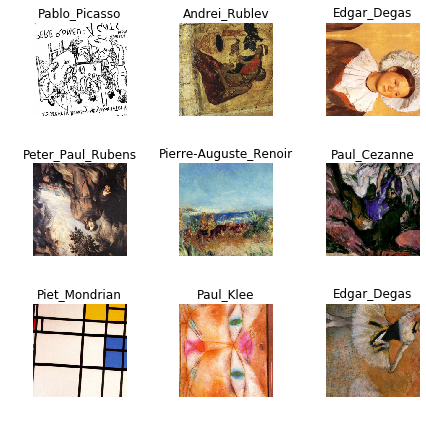

In [8]:
data.show_batch(rows=3, figsize=(6, 6))

### Getting ready for multi-label classification with data block API

In [9]:
import re

# Create new dataframe with just artists and genre
tags = pd.DataFrame({'folder_names': artists['name'],
              'tags': artists['genre']})

# Replace whitespaces with underscore to match folder names
for i, name in tags.iterrows():
    tags.loc[i, 'folder_names'] = re.sub('\s', '_', tags.loc[i, 'folder_names'])
    
tags.head(10)

,folder_names,tags
0,Amedeo_Modigliani,Expressionism
1,Vasiliy_Kandinskiy,"Expressionism,Abstractionism"
2,Diego_Rivera,"Social Realism,Muralism"
3,Claude_Monet,Impressionism
4,Rene_Magritte,"Surrealism,Impressionism"
5,Salvador_Dali,Surrealism
6,Edouard_Manet,"Realism,Impressionism"
7,Andrei_Rublev,Byzantine Art
8,Vincent_van_Gogh,Post-Impressionism
9,Gustav_Klimt,"Symbolism,Art Nouveau"


In [10]:
# Save df to a CSV file
tags.to_csv('tags.csv')

In [11]:
# Experiment
ll = (ImageList.from_folder(path)
        .split_by_rand_pct()
       .label_from_folder()
       .transform(tfms, size=128)
       .add_test_folder()
       .databunch())

# Convert ImageList object to a DataFrame
ll_df = ll.to_df()

# Rename col_names
ll_df.columns = ['img_names', 'folder_names']

ll_df.head(10)

,img_names,folder_names
0,Henri_Rousseau/Henri_Rousseau_36.jpg,Henri_Rousseau
1,Henri_Rousseau/Henri_Rousseau_54.jpg,Henri_Rousseau
2,Henri_Rousseau/Henri_Rousseau_46.jpg,Henri_Rousseau
3,Henri_Rousseau/Henri_Rousseau_52.jpg,Henri_Rousseau
4,Henri_Rousseau/Henri_Rousseau_20.jpg,Henri_Rousseau
5,Henri_Rousseau/Henri_Rousseau_42.jpg,Henri_Rousseau
6,Henri_Rousseau/Henri_Rousseau_53.jpg,Henri_Rousseau
7,Henri_Rousseau/Henri_Rousseau_59.jpg,Henri_Rousseau
8,Henri_Rousseau/Henri_Rousseau_37.jpg,Henri_Rousseau
9,Henri_Rousseau/Henri_Rousseau_55.jpg,Henri_Rousseau


In [12]:
# Check shapes
tags.shape, ll_df.shape

((50, 2), (6757, 2))

In [13]:
# Merge two dataframes where `folder_names` matches
data_df = pd.merge(tags, ll_df, on='folder_names')

data_df

,folder_names,tags,img_names
0,Amedeo_Modigliani,Expressionism,Amedeo_Modigliani/Amedeo_Modigliani_183.jpg
1,Amedeo_Modigliani,Expressionism,Amedeo_Modigliani/Amedeo_Modigliani_81.jpg
2,Amedeo_Modigliani,Expressionism,Amedeo_Modigliani/Amedeo_Modigliani_63.jpg
3,Amedeo_Modigliani,Expressionism,Amedeo_Modigliani/Amedeo_Modigliani_84.jpg
4,Amedeo_Modigliani,Expressionism,Amedeo_Modigliani/Amedeo_Modigliani_42.jpg
5,Amedeo_Modigliani,Expressionism,Amedeo_Modigliani/Amedeo_Modigliani_108.jpg
6,Amedeo_Modigliani,Expressionism,Amedeo_Modigliani/Amedeo_Modigliani_123.jpg
7,Amedeo_Modigliani,Expressionism,Amedeo_Modigliani/Amedeo_Modigliani_67.jpg
8,Amedeo_Modigliani,Expressionism,Amedeo_Modigliani/Amedeo_Modigliani_36.jpg
9,Amedeo_Modigliani,Expressionism,Amedeo_Modigliani/Amedeo_Modigliani_143.jpg


Experiment success!

### Data block API

In [14]:
# Transformation (again just to remind myself)
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_warp=0.)  # Exactly as lecture. These transforms counterproductive here

In [15]:
# path needs changing?
path

PosixPath('../input/images/images')

`path` argument does not really need changing. `cols` argument needs to be specified to the column which contains the relative path to the images. [See documentation](https://docs.fast.ai/data_block.html#ItemList.from_df).

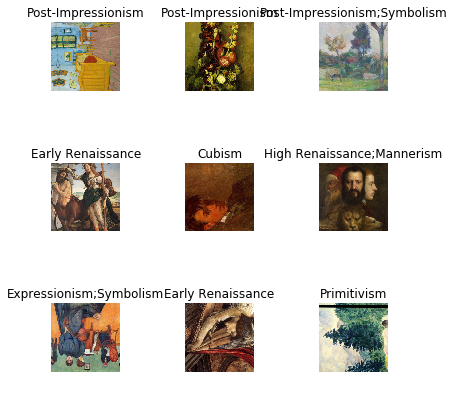

In [16]:
data = (ImageList.from_df(data_df, Path('../input/images/images/'), cols=2)   # `cols` is an index parameter
        .split_by_rand_pct(0.2)
        .label_from_df(label_delim=',', cols='tags')
        .transform(tfms, size=224)
        .databunch()
        .normalize(imagenet_stats))

data.show_batch(rows=3, figsize=(6, 6))

### Training

In [17]:
# Metrics
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

# Learning
learn = cnn_learner(data, models.resnet34, metrics=[acc_02, f_score], model_dir='/tmp/models')

# Finding LR
learn.lr_find()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 81915299.35it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


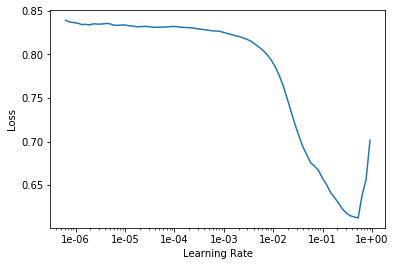

In [18]:
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(5, max_lr=slice(1e-03, 1e-005))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.827623,0.758414,0.066186,0.204919,04:12
1,0.824592,0.747967,0.065833,0.205367,04:10
2,0.820132,0.745194,0.064936,0.205466,04:09
3,0.814968,0.744462,0.064487,0.205852,04:10
4,0.815051,0.743422,0.064712,0.205736,04:10


In [20]:
data.c

24

In [21]:
data.classes

['Abstract Expressionism',
 'Abstractionism',
 'Art Nouveau',
 'Baroque',
 'Byzantine Art',
 'Cubism',
 'Early Renaissance',
 'Expressionism',
 'High Renaissance',
 'Impressionism',
 'Mannerism',
 'Muralism',
 'Neoplasticism',
 'Northern Renaissance',
 'Pop Art',
 'Post-Impressionism',
 'Primitivism',
 'Proto Renaissance',
 'Realism',
 'Romanticism',
 'Social Realism',
 'Suprematism',
 'Surrealism',
 'Symbolism']

In [22]:
learn.save('rn34')

### Training with resent50

In [23]:
learn.unfreeze()

In [24]:
# Change transformation
tfms = get_transforms()

In [25]:
data = (ImageList.from_df(data_df, Path('../input/images/images/'), cols=2)
        .split_by_rand_pct(0.2)
        .label_from_df(label_delim=',', cols='tags')
        .transform(tfms, size=300)
        .databunch()
        .normalize(imagenet_stats))

**Question:** What to keep in mind when choosing the accuracy threshold?

In [26]:
# Increase threshold
acc_03 = partial(accuracy_thresh, thresh=0.5)
f_score = partial(fbeta, thresh=0.5)

# Learning
learn = cnn_learner(data, models.resnet50, metrics=[acc_03, f_score], model_dir='/tmp/models')

# Finding LR
learn.lr_find()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.torch/models/resnet50-19c8e357.pth
102502400it [00:04, 24088029.08it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


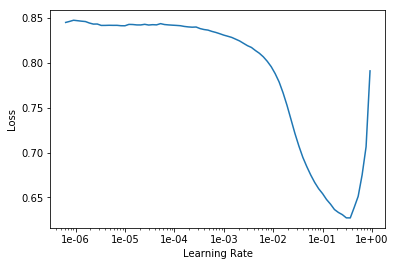

In [27]:
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(5, slice(1e02, 1e01))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,205.060135,10223118336.000000,0.377436,0.199815,05:15
1,498.541382,113638.500000,0.734327,0.140198,05:08
2,142.642441,75.116325,0.553269,0.236356,05:02
3,31.391441,1.018308,0.785705,0.217689,04:59
4,6.562198,0.306633,0.948462,0.000000,04:57


**Question:** How to interpret `accuracy_thresh` and `fbeta` here?